In [18]:
import itertools
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

|   | 0   | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10    |   
|---|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-------|
| 0 |     |     |     |     |     |     |     |     |     |     |       |
| 1 |     |     |     |     |     |     |     |     |     |     |       |
| 2 |     |     |     |     |     |     |     |     |     |     |       |
| 3 |     | end |     |     |     |     |     |     |     |     |       |
| 4 |     |     |     |     |     |     |     |     |     |     |       |
| 5 |     |     |     | end |     |     |     |     |     |     |       |
| 6 |     |     |     |     |     |     |     |     |     |     |       |
| 7 |     |     |     |     |     |     |     |     |     |     |       |

In [19]:
class GridWorldEnv:
    def __init__(self, N=7, M=10):
        self.N = N
        self.M = M
        self.observation_space = [(i, j) for i in range(N) for j in range(M)]
        self.action_space = [(0, 1), (0, -1), (1, 0), (-1, 0)]
        self.terminal_states = [(3, 1), (5, 3)]
        self.holes = [(0, 7)]
        self.damping_states = [(6, 9), (4, 0), (1, 4)]
        self.reset()

    def reset(self):
        self.state = (0, 0)
        self.is_terminated = False
        self.total_reward = 0

    def get_transition_probaility(self, start_state, action, end_state):
        if start_state in self.terminal_states:
            return 0

        expected_state = tuple(np.array(start_state) + np.array(action))
        if expected_state in self.terminal_states:
            return 1
        
        if expected_state in self.holes:
            return 0

        if expected_state[0] < 0 or expected_state[0] >= self.N or expected_state[1] < 0 or expected_state[1] >= self.M:
            return 0

        if expected_state in self.damping_states:
            return 0.8
        else:
            return 0.7

    def get_reward(self, start_state, action, end_state):
        if end_state in self.terminal_states:
            return 10
        elif end_state in self.holes:
            return -10
        elif end_state in self.damping_states:
            return -2
        else:
            return -1

    def step(self, action):
        if self.state in self.terminal_states:
            self.is_terminated = True
            reward = np.nan
            return self.state, reward, self.is_terminated

        current_state = self.state
        next_state = None  # Initialize next_state
        max_prob = 0
        for possible_state in self.observation_space:
            p = self.get_transition_probaility(current_state, action, possible_state)
            if p > max_prob:
                max_prob = p
                next_state = possible_state

        reward = self.get_reward(current_state, action, next_state)

        self.state = next_state
        self.total_reward += reward

        return self.state, reward, self.is_terminated


In [20]:
def value_iteration(env, gamma=0.9, epsilon=0.0001):
    V = {s: 0 for s in env.observation_space}
    while True:
        delta = 0
        for s in env.observation_space:
            v = V[s]
            max_v = float('-inf')
            for a in env.action_space:
                expected_v = 0
                for s_prime in env.observation_space:
                    r = env.get_reward(s, a, s_prime)
                    p = env.get_transition_probaility(s, a, s_prime)
                    expected_v += p * (r + gamma * V[s_prime])
                max_v = max(max_v, expected_v)
            V[s] = max_v
            delta = max(delta, abs(v - V[s]))
        if delta < epsilon:
            break
    return V

In [21]:
def simulate_agent(env, agent, episodes=100):
    total_rewards = []
    for _ in range(episodes):
        env.reset()
        episode_reward = 0
        while not env.is_terminated:
            action = agent.policy()
            _, reward, is_terminated = env.step(action)
            episode_reward += reward
        total_rewards.append(episode_reward)
    avg_reward = np.mean(total_rewards)
    return avg_reward

In [22]:
def plot_heatmap(values, rows, cols):
    plt.imshow(np.array(list(values.values())).reshape(rows, cols), cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.show()

In [23]:
env = GridWorldEnv(10, 10)
env.state

action = (1, 0)
next_state, reward, is_terminated = env.step(action)

print("Next state: ", next_state)
print("Reward: ", reward)

Next state:  (0, 0)
Reward:  -1


In [24]:
# Create GridWorld environment
env = GridWorldEnv(7, 10)

In [ ]:
class RandomActionAgent:
    def __init__(self, env):
        self.env = env

    def policy(self):
        action = random.choice(self.env.action_space)[0]
        return action

env.reset()
agent = RandomActionAgent(env)

while not env.is_terminated:
  current_state = env.state
  action =  agent.policy()
  next_state, reward, is_terminated = env.step(action)
  print(current_state, action, reward, next_state)

env.total_reward

In [26]:
class DPAgent:
  def __init__(self, env):
    self.env = env
    self.gamma = 1

    self.v = dict(zip(self.env.observation_space, np.zeros(self.env.N*self.env.M)))
    self.is_trained = False


  def policy(self):
    if not self.is_trained:
      action = random.choices(self.env.action_space)[0]
    else:
      s = self.env.state
      max = -np.inf
      for a in self.env.action_space:
        term = 0
        for s_prime in self.env.observation_space:
          term+= self.env.get_transition_probaility(s, a, s_prime) * (self.env.get_reward(s, a, s_prime) + self.gamma * self.v[s_prime])
        if term > max:
          max = term
          action = a

    return action

  def train(self, iter_limit = 1000):

    print("performing training...")

    self.v = dict(zip(self.env.observation_space, np.zeros(self.env.N*self.env.M)))

    iter = 0
    while iter< iter_limit:
      for s in self.env.observation_space:
        max = -np.inf
        for a in self.env.action_space:
          term2 = 0
          for s_prime in self.env.observation_space:
            term2+= self.env.get_transition_probaility(s, a, s_prime) * (self.env.get_reward(s, a, s_prime) + self.gamma*self.v[s_prime])
          if term2 > max:
            max = term2
        self.v[s] = max
      iter+=1

    self.is_trained = True

    print(np.array(list(self.v.values())).reshape(self.env.N, self.env.M))

In [27]:
# Perform value iteration to get optimal state values
optimal_state_values = value_iteration(env)


In [ ]:
# Calculate average total rewards with and without training
random_agent = RandomActionAgent(env)
dp_agent = DPAgent(env)

avg_reward_no_training = simulate_agent(env, random_agent)
dp_agent.train(iter_limit=100)
avg_reward_with_training = simulate_agent(env, dp_agent)

# Print average rewards
print("Average reward without training:", avg_reward_no_training)
print("Average reward with training:", avg_reward_with_training)

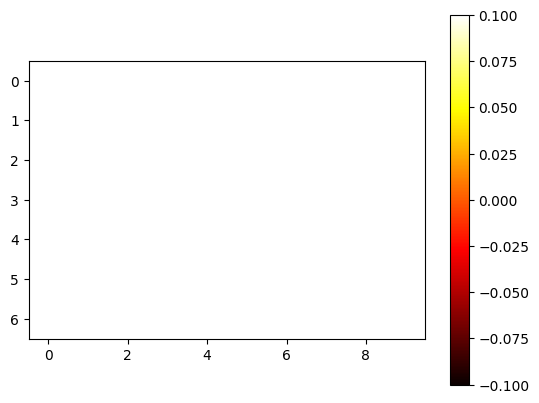

In [30]:

# Create heatmap for optimal state values
plot_heatmap(optimal_state_values, rows=7, cols=10)